<a href="https://colab.research.google.com/github/franjgs/LabelSwitching/blob/main/Asymmetric_Label_Switching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Label Switching

---



## Ensembles

Machine ensembles allow to improve the performance of single learning
machines by aggregating the outputs of a number of them -learning units or
learners- that are trained under diverse conditions [1, 2]. Since the 1990s,
they served, in particular, to alleviate the practical limitations that the size
of training datasets impose to the approximation capacity of shallow Multi-
Layer Perceptrons (MLPs).

### Diversity

#### Bagging

Bagging type diversifications (resampling) introduce some risks {deletion of critical samples, emphasis of outliers, and even sample generation can create distortions in the class likelihoods.

#### Label Switching

## Imbalanced Problems

Imbalanced classification deserves much attention because it appears in
many important real world problems of different application areas. Those
problems have much different class population sizes and/or classications
costs.
As a consequence, conventionally designed discriminative classifiers do
not provide satisfactory results: They naturally tend to decide in favour of
the majority class. Among the procedures that serve to combat this undesirable
effect {references [10, 11, 12, 13, 14, 15] offer clear and complete
perspectives,{ there are methods based on sample preprocessing, and other
that apply modified learning algorithms, such as one-class or modified kernel
Support Vector Machines [16, 17]. Fuzzy formulations have also been applied
[18]. Recently, there are contributions that include time-sensitive elements
[19, 20].

### Techniques for Imbalanced Problems
The techniques based on preprocessing the (training) samples are simple
and effective. 

They include, 

1. Increasing the cost of wrongly classifying the minority samples [21]
2. Oversampling the minority and/or undersampling the majority classes [22, 23]{that can be considered as asymmetric versions of bagging,
3. Generating minority samples {SMOTE [24] is a successful mechanism from which many modications have been proposed.

Obviously, the classification problems that result from these processes are more balanced, and, under certain conditions, the solution of the original classification problem can be obtained from their results.

###Asymmetric Label Switching

# Code for Assymetric Label Switching

# Load some standard packages

In [1]:
import numpy as np
import pandas as pd

import time
import scipy.io as sio
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

In [2]:
from sklearn import metrics
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler

def perf_measure(y_actual, y_hat):

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]:
            if y_actual[i]==1:
                TP += 1
            else:
                TN += 1
        else:
            if y_actual[i]==1:
                FN += 1
            else:
                FP += 1

    return TP, FP, TN, FN

def ROC_points(L, f):

  """
  Calculates the value of the discriminant function for a dx1 dimensional
  sample given covariance matrix and mean vector.
  """

  FPR=[]
  TPR=[]
  P=len(np.where(L==+1)[0])
  N=len(np.where(L==-1)[0])

  B=sorted(range(len(f)),key=lambda x:f[x],reverse=True)

  L_sorted=L[B]
  FP=0
  TP=0
  f_prev=1e45
  i=0

  while i < len(L_sorted):
      if f[i] !=f_prev:
          FPR.append(FP/float(N))
          TPR.append(TP/float(P))
          f_prev=f[i]
      if L_sorted[i]==+1:
          TP+=1
      else:
          FP+=1
      i+=1

  FPR.append(FP/float(N))
  TPR.append(TP/float(P))

  return FPR, TPR

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier

nh = 3
# MLP0 = MLPRegressor(solver='lbfgs', alpha = 1, activation = 'tanh', hidden_layer_sizes=(nh, ), max_iter=1000) #, random_state=1)
MLPc = MLPClassifier(solver='lbfgs', alpha = 0.1, activation = 'tanh', hidden_layer_sizes=(nh, ), max_iter=750) #, random_state=1)

classifiers = [
    KNeighborsClassifier(3),                                # 0. Accepatble performance 
    SVC(kernel="linear", C=0.025, probability=True),        # 1. Very Bad performance. Very Slow (5-fold validation to estimate pyX)
    SVC(gamma=2, C=1, probability=True),                    # 2. Very Bad performance. Very Slow (5-fold validation to estimate pyX)
    GaussianProcessClassifier(1.0 * RBF(1.0)),              # 3. Very very Slow
    DecisionTreeClassifier(max_depth=5),                    # 4. Accepatble performance 
    RandomForestClassifier(max_depth=5, n_estimators=3),    # 5. Bad Performace  max_features=1),
    GradientBoostingClassifier(n_estimators = 3),           # 6. Very Bad performance
    AdaBoostClassifier(n_estimators = 3, base_estimator = GaussianNB(), learning_rate=1),   # 7. Bad performance
    GaussianNB(),                                           # 8. Medium Performace. Very Fast
    QuadraticDiscriminantAnalysis(),                        # 9.  Accepatble performance. Very fast. Fails at execution
    MLPc                                                    # 10. Best Performace. Slow convergence.
    ]

K_ens= [1,11, 31] #, 101]
learner_ens = classifiers[10]

Label Switching

Conventional (Symmetric) Switching 

In [4]:
def breiman_switching(y, frsw=0.0):

    # frsw: Label Switching Rate from Minority to Majority class

    ysw=1*y;

    idx1=np.where(y==+1)[0]
    idx0=np.where(y==-1)[0]

    n_flipped=int(round(len(idx1)*frsw))

    idx1_sw=np.random.choice(idx1, n_flipped, replace=False)
    ysw[idx1_sw]=-y[idx1_sw]

    idx0_sw=np.random.choice(idx0, n_flipped, replace=False)
    ysw[idx0_sw]=-y[idx0_sw]

    return ysw

Asymmetric Label Switching

In [5]:
def label_switching(y, alphasw=0.0, betasw=0.0):

    # alphasw: Label Switching Rate from Majority to Minority class
    # betasw: Label Switching Rate from Minority to Majority class

    ysw=1*y;

    idx1=np.where(y==+1)[0]
    l1=len(idx1)
    bet_1=int(round(l1*betasw))
    idx1_sw=np.random.choice(idx1,bet_1, replace=False)
    ysw[idx1_sw]=-y[idx1_sw]

    idx0=np.where(y==-1)[0]
    l0=len(idx0)
    alph_0=int(round(l0*alphasw))
    idx0_sw=np.random.choice(idx0,alph_0, replace=False)
    ysw[idx0_sw]=-y[idx0_sw]

    return ysw

Load UCI Datasets

Load the dataset via its URL and check the following:

- Are the headers showing up properly?
- Look at the first 5 and the last 5 rows, do they seem to be in order?
- Does the dataset have the correct number of rows and columns as described in the UCI page? 
 - Remember, that UCI does not count the y variable (column of values that we might want to predict via a machine learning model) as an "attribute" but rather as a "class attribute" so you may end up seeing a number of columns that is one greater than the number listed on the UCI website.
- Does UCI list this dataset as having missing values? Check for missing values and see if your analysis corroborates what UCI reports?
- if `NaN` values or other missing value indicators are not being detected by `df.isnull().sum()` find a way to replace whatever is indicating the missing values with `np.NaN`.
- Use the .describe() function in order to see the summary statistics of both the numeric and non-numeric columns. 

In [6]:
# Load data from URL using pandas read_csv method
filename_i='balance-scale'
URL_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/'+filename_i+'/'+filename_i+'.data'
# print(URL_path)
Xy = pd.read_csv(URL_path)
di = {'L': -1, 'B': +1, 'R': -1}
Xy.replace({'B': di}, inplace=True)
y = np.array(Xy['B'])
X = np.array(Xy.drop(['B'], axis=1))

In [7]:

filename_i='wine-quality'

URL_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/'+filename_i+'/winequality-red.csv'
# print(URL_path)
Xy = pd.read_csv(URL_path,  sep=';')

Xy['quality'] = Xy['quality'].apply(lambda x: +1 if x <= 4 else -1)
y = np.array(Xy['quality'])
X = np.array(Xy.drop(['quality'], axis=1))


In [8]:
dim = X.shape[1]

N0 = len(np.where(y==-1)[0])
N1 = len(np.where(y==1)[0])

index0 = np.where(y==-1)[0]
index1 = np.where(y==1)[0]

print('N0: %d. N1: %d' % (N0 , N1))

N0: 1536. N1: 63


In [9]:
######## Costes y Probabilidades ########
P0=float(N0)/float(N0+N1)
P1=float(N1)/float(N0+N1)
QP=P0/P1

P0_1=0.5 # Para la balanced accuracy
P1_1=0.5

C10=1 # False Positive (FP)
C00=0 # True Negative (TN)
C01=5 # False Negative (FN)   : QC=1/5
C11=0 # True Positive (TP)

QC=float(C10-C00)/float(C01-C11)
QCT=QC

Q=QC*QP
######## Costes y Probabilidades ########

Common Parameters

In [10]:
###################### COMMON PARAMETERS ######################

n_folds = 1
Nruns   = 20
Test_size = 30

index0 = np.where(y==-1)[0]
index1 = np.where(y==1)[0]

l_test0 = int(N0*0.01*Test_size)
l_test1 = int(N1*0.01*Test_size)

Alpha = np.linspace(0,0.45,10) # Label Switching Rate from Majority to Minority class
Alpha = [0, 0.1, 0.2, 0.3, 0.4]
Beta = np.linspace(0,0.2,5)     # Label Switching Rate from Minority to Majority class
Beta = [0]
eps=np.finfo(float).eps

In [11]:
filename_o=filename_i+'_NW_nh_'+str(nh)+'_TS_'+str(Test_size)+'.mat'

perf_sw_K1 = np.zeros([Nruns, len(Alpha), len(Beta), len(K_ens), 6]) # Confusion Matrix + MCC + F1
perf_sw_K2 = np.zeros([Nruns, len(Alpha), len(Beta), len(K_ens)])   # CBL
perf_sw_K3 = np.zeros([Nruns, len(Alpha), len(Beta), len(K_ens)])   # AuC

lROC=1001
mean_fpr = np.logspace(-4, 0, lROC)
perf_sw_K4=np.zeros([len(Alpha), len(Beta), len(K_ens), lROC, 2])     # Test:  ROC(FPR, TPR)
 

Main Loop


TRAIN TIME:
56s
Alpha: 0.00. Beta: 0.00. IR_sw: 23.91.
MLP: 1. F1: 0.208119. +- 0.073135 MCC: 0.179743. +- 0.079039 TPR: 0.288889. FPR: 0.055217
MLP: 11. F1: 0.222024. +- 0.032674 MCC: 0.191786. +- 0.036488 TPR: 0.302778. FPR: 0.055652
MLP: 31. F1: 0.235163. +- 0.052877 MCC: 0.207062. +- 0.058830 TPR: 0.325000. FPR: 0.055543
TRAIN TIME:
59s
Alpha: 0.10. Beta: 0.00. IR_sw: 6.33.
MLP: 1. F1: 0.169566. +- 0.045753 MCC: 0.144624. +- 0.058960 TPR: 0.363889. FPR: 0.114565
MLP: 11. F1: 0.258963. +- 0.062922 MCC: 0.230399. +- 0.067281 TPR: 0.316667. FPR: 0.045000
MLP: 31. F1: 0.261887. +- 0.070450 MCC: 0.234164. +- 0.074363 TPR: 0.319444. FPR: 0.043152
TRAIN TIME:
68s
Alpha: 0.20. Beta: 0.00. IR_sw: 3.31.
MLP: 1. F1: 0.143013. +- 0.037181 MCC: 0.116302. +- 0.048139 TPR: 0.377778. FPR: 0.155543
MLP: 11. F1: 0.251542. +- 0.055168 MCC: 0.222509. +- 0.058445 TPR: 0.327778. FPR: 0.050978
MLP: 31. F1: 0.241269. +- 0.062118 MCC: 0.210267. +- 0.066592 TPR: 0.291667. FPR: 0.045870
TRAIN TIME:
72s
Alpha

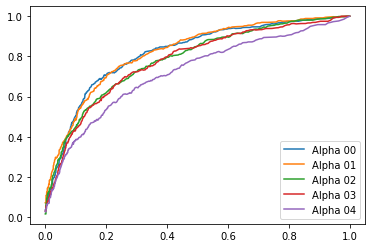

In [12]:
b_idx=0
for beta in Beta:
    a_idx=0
    for alpha in Alpha:        
        start = time.time()
        for nruns in range(Nruns):
            
            idx0_test = np.random.choice(index0, l_test0, replace=False)
            idx1_test = np.random.choice(index1, l_test1, replace=False)
            idx_test = np.sort(np.concatenate((idx0_test, idx1_test), axis=0))

            X_train = np.delete(X, idx_test, axis=0)
            X_test = X[idx_test]
            y_train = np.delete(y, idx_test, axis=0)
            y_test = y[idx_test]
                         
            N0_tr = len(np.where(y_train==-1)[0])
            N1_tr = len(np.where(y_train==1)[0])

            P0_tr = float(N0_tr)/float(N0_tr+N1_tr)
            P1_tr = float(N1_tr)/float(N0_tr+N1_tr)
            
            QP_tr = P0_tr/P1_tr

            y_true = y_test

            k_idx = 0
            for K in K_ens:

                o_x=np.ones([len(y_test)])

                o_x_tst_ens=np.zeros([K,len(y_test)])

                model_name=model_name = type(learner_ens).__name__                
                MLP_ens = [learner_ens for kkk in range(K)]

                for k in range(K):              
                    #################### NORM ####################
                    scaler = StandardScaler()
                    scaler.fit(X_train)
                    X_train_n = scaler.transform(X_train)
                    X_test_n = scaler.transform(X_test)
                    #################### NORM ####################
                    
                    ################## Switching ##################
                    if alpha==0 and beta==0:
                        X_train_s, y_train_s = X_train_n, y_train
                    else:
                        X_train_s = X_train_n
                        y_train_s = label_switching(y_train, alpha, beta)
                    
                    
                    N0_sw = len(np.where(y_train_s==-1)[0])
                    N1_sw = len(np.where(y_train_s==1)[0])

                    P0_sw = float(N0_sw)/float(N0_sw+N1_sw)
                    P1_sw = float(N1_sw)/float(N0_sw+N1_sw)

                    QP_sw = P0_sw/P1_sw
                    ################## Switching #################
                    MLP_ens[k] = MLP_ens[k].fit(X_train_s, y_train_s)
 
                    y_pred = MLP_ens[k].predict_proba(X_test_n)[:,1]*2-1
                    
                    o_x_tst_ens[k] = y_pred
                    
                o_x_tst=o_x_tst_ens.mean(0)
                pyX_test=(0.5*(o_x_tst+1)-alpha)/(1-alpha-beta)
                
                FPR_vec, TPR_vec, thresholds = roc_curve(y_true, pyX_test)
                roc_auc = auc(FPR_vec, TPR_vec)
                perf_sw_K3[nruns,a_idx,b_idx, k_idx] = roc_auc

                f_ROC = interp1d(FPR_vec, TPR_vec)

                perf_sw_K4[a_idx,b_idx,k_idx,:,0] += mean_fpr
                perf_sw_K4[a_idx,b_idx,k_idx,:,1] += f_ROC(mean_fpr)

                gamma = 1*(2 * (alpha + (1 - alpha - beta) * (QCT / (QCT + 1))) - 1)
 
                o_x2=np.ones([len(y_test)])
                o_x2[o_x_tst < gamma] = -1

                TP, FP, TN, FN = perf_measure(y_true, o_x2) 

                # Sensitivity, hit rate, recall, or true positive rate
                TPR=TP/float(TP+FN)

                # Specificity (SPC) or true negative rate
                SPC=TN/float(TN+FP)

                # False positive rate: FPR=FP/float(FP+TN) = 1-SPC
                FPR=1-SPC

                # False negative rate
                FNR=1-TPR

                # Mathhews correlation coefficient
                if (((TP + FP) == 0) or ((TP + FN) == 0) or ((TN + FP) == 0) or ((TN + FN) == 0)):
                    MCC = 0
                else:
                    MCC = (TP * TN - FP * FN) / np.sqrt(float(TP + FP) * float(TP + FN) * float(TN + FP) * float(TN + FN))

                # Accuracy
                ACC=(TP+TN)/float(TP+FN+FP+TN)

                # F1 Score
                F1=2*TP/float(2*TP+FP+FN)

                perf_sw_K1[nruns,a_idx,b_idx,k_idx,0]=FPR
                perf_sw_K1[nruns,a_idx,b_idx,k_idx,1]=TPR
                perf_sw_K1[nruns,a_idx,b_idx,k_idx,2]=SPC
                perf_sw_K1[nruns,a_idx,b_idx,k_idx,3]=ACC
                perf_sw_K1[nruns,a_idx,b_idx,k_idx,4]=MCC
                perf_sw_K1[nruns,a_idx,b_idx,k_idx,5]=F1

                perf_sw_K2[nruns,a_idx,b_idx,k_idx]=(FPR*P0_1+FNR*P1_1) # Balanced Accuracy

                k_idx+=1

        end = time.time()
        print('TRAIN TIME:')
        print('%.2gs'%(end-start))
        print('Alpha: %.2f. Beta: %.2f. IR_sw: %.2f.'  %(alpha,beta,QP_sw))

        
        for k_idx in range(len(K_ens)):
            print('MLP: %d. F1: %f. +- %f MCC: %f. +- %f TPR: %f. FPR: %f' %(K_ens[k_idx],
                                                                             np.mean(perf_sw_K1[:,a_idx,b_idx,k_idx,5]), 
                                                                             np.std(perf_sw_K1[:,a_idx,b_idx,k_idx,5]), 
                                                                             np.mean(perf_sw_K1[:,a_idx,b_idx,k_idx,4]), 
                                                                             np.std(perf_sw_K1[:,a_idx,b_idx,k_idx,4]), 
                                                                             np.mean(perf_sw_K1[:,a_idx,b_idx,k_idx,1]), 
                                                                             np.mean(perf_sw_K1[:,a_idx,b_idx,k_idx,0])))
        a_idx+=1
    b_idx+=1

perf_sw_K1_std = np.std(perf_sw_K1, axis=0)
perf_sw_K1 = np.mean(perf_sw_K1, axis=0)

perf_sw_K2_std = np.std(perf_sw_K2, axis=0)
perf_sw_K2 = np.mean(perf_sw_K2, axis=0)

perf_sw_K3_std = np.std(perf_sw_K3, axis=0)
perf_sw_K3 = np.mean(perf_sw_K3, axis=0)

perf_sw_K4 /= n_folds*Nruns

tprPoints = perf_sw_K4[:,0,1,:,0]
fprPoints = perf_sw_K4[:,0,1,:,1]
plt.plot(tprPoints[0,:],fprPoints[0,:], label='Alpha 00')
plt.plot(tprPoints[1,:],fprPoints[1,:], label='Alpha 01')
plt.plot(tprPoints[2,:],fprPoints[2,:], label='Alpha 02')
plt.plot(tprPoints[3,:],fprPoints[3,:], label='Alpha 03')
plt.plot(tprPoints[4,:],fprPoints[4,:], label='Alpha 04')
plt.legend()
plt.show()

sio.savemat(model_name+'_'+filename_o, {'perf_sw_K1': perf_sw_K1,  
                                        'perf_sw_K2': perf_sw_K2, 
                                        'perf_sw_K3': perf_sw_K3, 
                                        'perf_sw_K1_std': perf_sw_K1_std,  
                                        'perf_sw_K2_std': perf_sw_K2_std, 
                                        'perf_sw_K3_std': perf_sw_K3_std, 
                                        'perf_sw_K4': perf_sw_K4, 
                                        'Alpha':Alpha, 'Beta': Beta, 'K_ens': K_ens})
